In [2]:
import xarray
import numpy as np
from sklearn.linear_model import ElasticNet, LassoLars, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch, AsinhStretch

%matplotlib inline

# Inversion Tests

Some tests to see how easy it is to invert the MOXSI data

Load the response matrix and EM cube

In [3]:
response_matrix = xarray.open_dataarray('moxsi_response_matrix.nc')

In [4]:
response_matrix_total = response_matrix.sum(dim='spectral_order').rename({'pixel_fov': 'pixel_x'})

In [5]:
response_matrix_total

<xarray.DataArray (pixel_x: 338, pixel_detector: 2000, log_temperature: 60)>
array([[[5.47814223e-40, 3.69993772e-39, 1.94958896e-38, ...,
         3.54270315e-33, 3.46808906e-33, 3.39052206e-33],
        [5.37407903e-40, 3.64142754e-39, 1.92480694e-38, ...,
         3.57883643e-33, 3.50438533e-33, 3.42679047e-33],
        [5.27135532e-40, 3.58307651e-39, 1.89881003e-38, ...,
         3.64502537e-33, 3.56380521e-33, 3.48082210e-33],
        ...,
        [1.73253895e-38, 5.44433530e-38, 1.44729630e-37, ...,
         3.76546405e-34, 3.67455789e-34, 3.58322216e-34],
        [1.73662874e-38, 5.44834886e-38, 1.44631722e-37, ...,
         3.67828793e-34, 3.59475551e-34, 3.50992945e-34],
        [1.74064531e-38, 5.45209437e-38, 1.44523028e-37, ...,
         3.64191502e-34, 3.55908754e-34, 3.47494412e-34]],

       [[5.58397589e-40, 3.75944844e-39, 1.97535564e-38, ...,
         3.50856419e-33, 3.43412174e-33, 3.35698097e-33],
        [5.47814223e-40, 3.69993772e-39, 1.94958896e-38, ...,
         3.54270315e-33, 3.46808906e-33, 3.39052206e-33],
        [5.37407903e-40, 3.64142754e-39, 1.92480694e-38, ...,
         3.57883643e-33, 3.50438533e-33, 3.42679047e-33],
...
        [5.37407903e-40, 3.64142754e-39, 1.92480694e-38, ...,
         3.57883643e-33, 3.50438533e-33, 3.42679047e-33],
        [5.47814223e-40, 3.69993772e-39, 1.94958896e-38, ...,
         3.54270315e-33, 3.46808906e-33, 3.39052206e-33],
        [5.58397589e-40, 3.75944844e-39, 1.97535564e-38, ...,
         3.50856419e-33, 3.43412174e-33, 3.35698097e-33]],

       [[1.74064531e-38, 5.45209437e-38, 1.44523028e-37, ...,
         3.64191502e-34, 3.55908754e-34, 3.47494412e-34],
        [1.73662874e-38, 5.44834886e-38, 1.44631722e-37, ...,
         3.67828793e-34, 3.59475551e-34, 3.50992945e-34],
        [1.73253895e-38, 5.44433530e-38, 1.44729630e-37, ...,
         3.76546405e-34, 3.67455789e-34, 3.58322216e-34],
        ...,
        [5.27135532e-40, 3.58307651e-39, 1.89881003e-38, ...,
         3.64502537e-33, 3.56380521e-33, 3.48082210e-33],
        [5.37407903e-40, 3.64142754e-39, 1.92480694e-38, ...,
         3.57883643e-33, 3.50438533e-33, 3.42679047e-33],
        [5.47814223e-40, 3.69993772e-39, 1.94958896e-38, ...,
         3.54270315e-33, 3.46808906e-33, 3.39052206e-33]]])
Coordinates:
  * log_temperature  (log_temperature) float64 5.0 5.05 5.1 ... 7.85 7.9 7.95
Dimensions without coordinates: pixel_x, pixel_detector

## 1. Observed EM

Create simulated MOXSI data

In [6]:
em_cube_observed = xarray.open_dataarray('observed-dem.nc')

In [7]:
moxsi_counts_observed = response_matrix_total.dot(em_cube_observed, dims=['log_temperature', 'pixel_x']).T

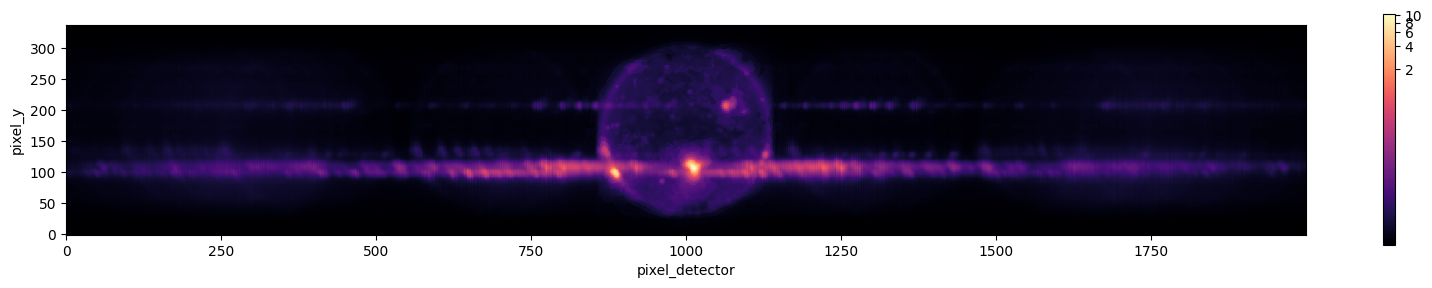

In [9]:
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot()
moxsi_counts_observed.plot.imshow(ax=ax, cmap='magma', norm=ImageNormalize(stretch=LogStretch()), interpolation='none')
ax.set_aspect(1)

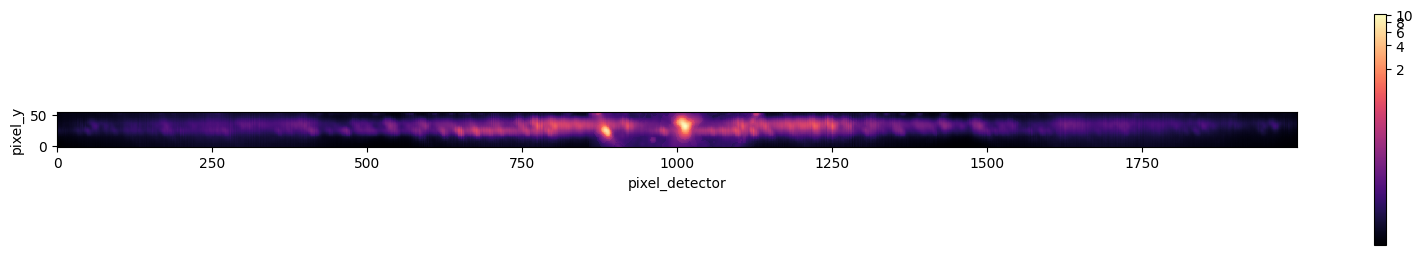

In [10]:
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot()
moxsi_counts_observed[75:130,:].plot.imshow(ax=ax, cmap='magma', norm=ImageNormalize(stretch=LogStretch()), interpolation='none')
ax.set_aspect(1)

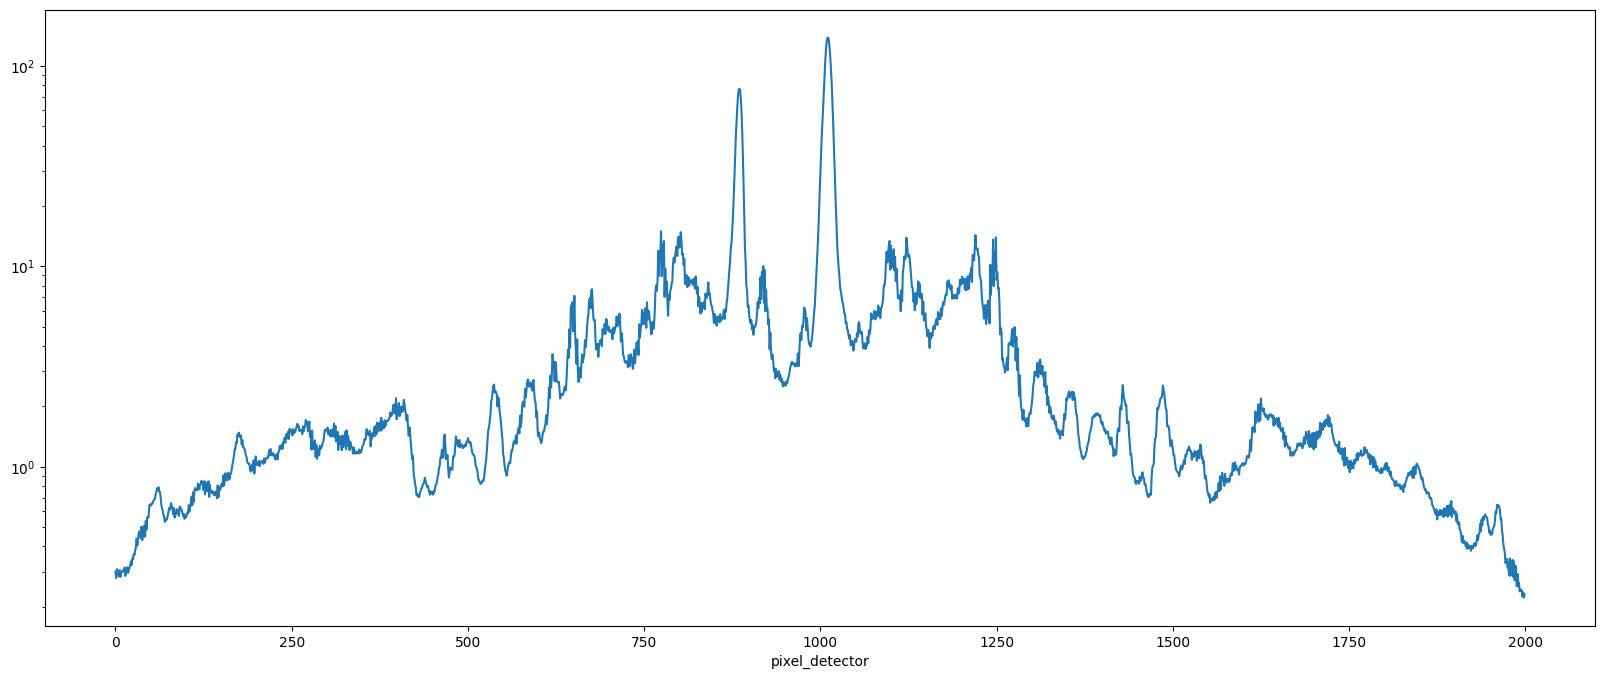

In [12]:
fig = plt.figure(figsize=(20,8))
moxsi_counts_observed[75:130,:].sum(dim='pixel_y').plot()
plt.yscale('log')
#plt.ylim(1e-4,1)

In [229]:
moxsi_counts_observed

<xarray.DataArray (pixel_y: 338, pixel_detector: 2000)>
array([[8.88842748e-06, 8.26483954e-06, 9.25301489e-06, ...,
        8.91252732e-06, 8.67358830e-06, 8.86702947e-06],
       [9.92176314e-06, 9.25198295e-06, 1.01512446e-05, ...,
        9.55712933e-06, 9.63087563e-06, 9.71864626e-06],
       [1.16514876e-05, 1.11142538e-05, 1.17011280e-05, ...,
        1.09602735e-05, 1.11107251e-05, 1.10209396e-05],
       ...,
       [1.38433505e-05, 1.33900401e-05, 1.41949669e-05, ...,
        1.39063150e-05, 1.42248696e-05, 1.40559468e-05],
       [1.26016401e-05, 1.21549025e-05, 1.30693955e-05, ...,
        1.26190121e-05, 1.27588297e-05, 1.26152542e-05],
       [1.13154978e-05, 1.06820666e-05, 1.18868067e-05, ...,
        1.10680595e-05, 1.09213840e-05, 1.10947184e-05]])
Dimensions without coordinates: pixel_y, pixel_detector

Now, try to do an actual inversion

In [15]:
x_ = response_matrix_total.stack(pixel_logT=('pixel_x', 'log_temperature'))

In [16]:
SCALING_CONSTANT = 1e30

In [19]:
#pipeline = make_pipeline(
#    StandardScaler(),
#    #ElasticNet(),
#    LassoLars()
#)
#model = LassoLars(verbose=1, alpha=1.5, positive=True, max_iter=1000)
#model = ElasticNetCV(
#    positive=True,
#    alphas=[1.5,],
#    l1_ratio=[.9e-5, 1e-4, 5e-4, 7.5e-4],
#    max_iter=2000,
#    n_jobs=-1,
#)
model = ElasticNet(
    positive=True,
    alpha=1.1,
    l1_ratio=1e-4,
    max_iter=2000,
)

In [20]:
model.fit(x_.values*SCALING_CONSTANT, moxsi_counts_observed[100,:].values, )

ElasticNet(alpha=1.1, l1_ratio=0.0001, max_iter=2000, positive=True)

In [22]:
em_coefficients = xarray.DataArray(
    model.coef_,
    dims=['pixel_logT'],
    coords={'pixel_logT': x_.pixel_logT},
)*SCALING_CONSTANT

In [23]:
recovered_moxsi_counts_observed = x_.dot(em_coefficients, dims=['pixel_logT'])

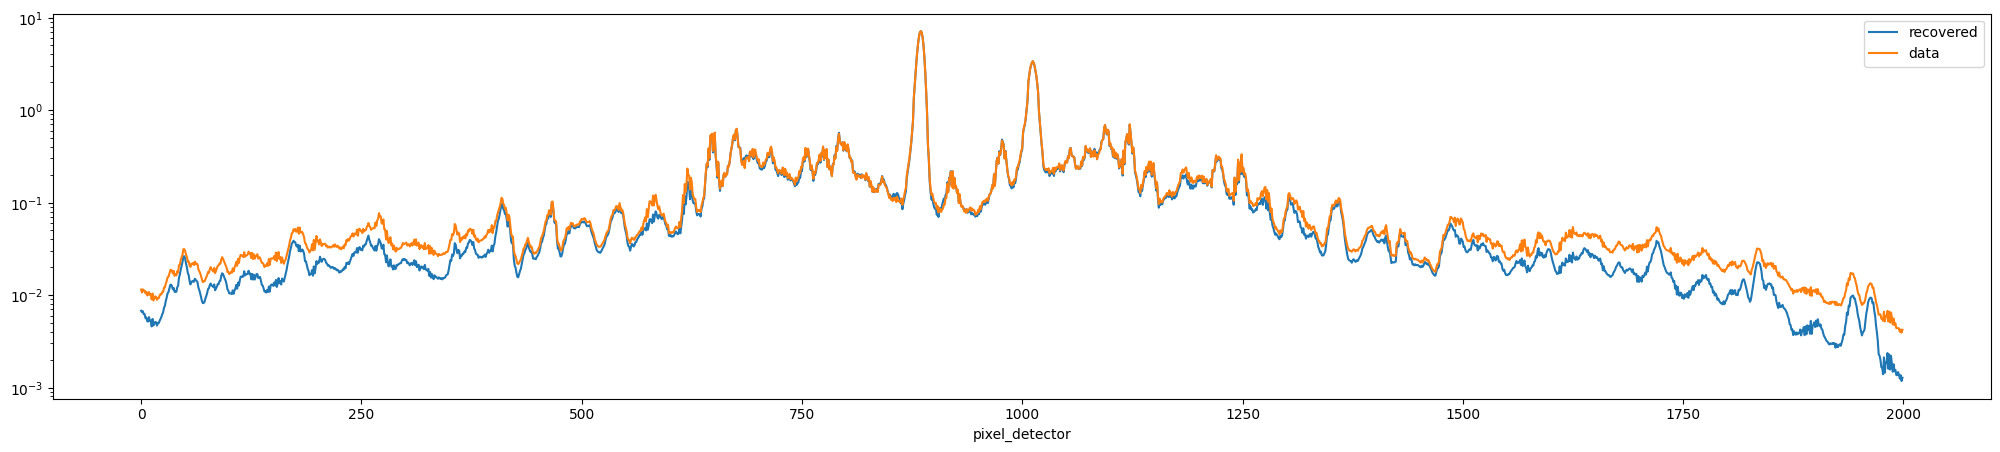

In [25]:
plt.figure(figsize=(25,5))
recovered_moxsi_counts_observed.plot(label='recovered')
moxsi_counts_observed[100,:].plot(label='data')
plt.yscale('log')
plt.legend()

In [26]:
em_recovered_observed = em_coefficients.unstack()

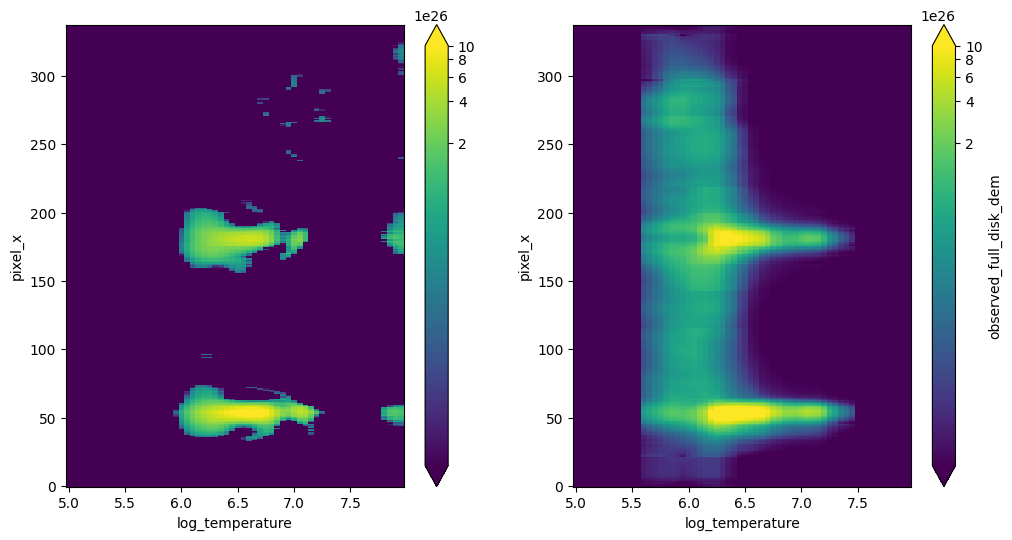

In [31]:
norm = ImageNormalize(vmin=1e23, vmax=1e27, stretch=LogStretch())
plt.figure(figsize=(12,6))
plt.subplot(121)
em_recovered_observed.plot(norm=norm)
plt.subplot(122)
em_cube_observed[100,...].plot(norm=norm)

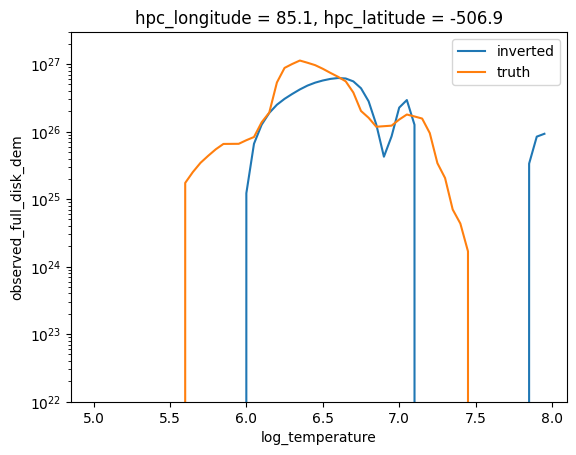

In [32]:
em_recovered_observed.isel(pixel_x=180).plot(label='inverted')
em_cube_observed.isel(pixel_y=100, pixel_x=180).plot(label='truth')
plt.yscale('log')
plt.ylim(1e22,3e27)
plt.legend()

## 2. Simulated EM

In [50]:
em_cube_simulated = xarray.open_dataarray('simulated-dem.nc')[78:144,150:204,...]

In [51]:
em_cube_simulated

<xarray.DataArray 'simulated_dem' (pixel_y: 66, pixel_x: 54, log_temperature: 60)>
[213840 values with dtype=float64]
Coordinates:
    hpc_longitude    (pixel_y, pixel_x) float64 ...
    hpc_latitude     (pixel_y, pixel_x) float64 ...
  * log_temperature  (log_temperature) float64 5.0 5.05 5.1 ... 7.85 7.9 7.95
Dimensions without coordinates: pixel_y, pixel_x
Attributes:
    bunit:     cm-5
    wcsaxes:   2
    crpix1:    169.5
    crpix2:    169.5
    cdelt1:    0.0020555555555556
    cdelt2:    0.0020555555555556
    cunit1:    deg
    cunit2:    deg
    ctype1:    HPLN-TAN
    ctype2:    HPLT-TAN
    crval1:    0.0
    crval2:    0.0
    lonpole:   180.0
    latpole:   0.0
    mjdref:    0.0
    date-obs:  2020-11-09T17:59:57.340
    mjd-obs:   59162.749969213
    rsun_ref:  696000000.0
    dsun_obs:  148154617444.64
    hgln_obs:  0.0
    hglt_obs:  3.4233542990553

In [52]:
moxsi_counts_simulated = response_matrix_total[150:204,...].dot(em_cube_simulated, dims=['log_temperature', 'pixel_x']).T

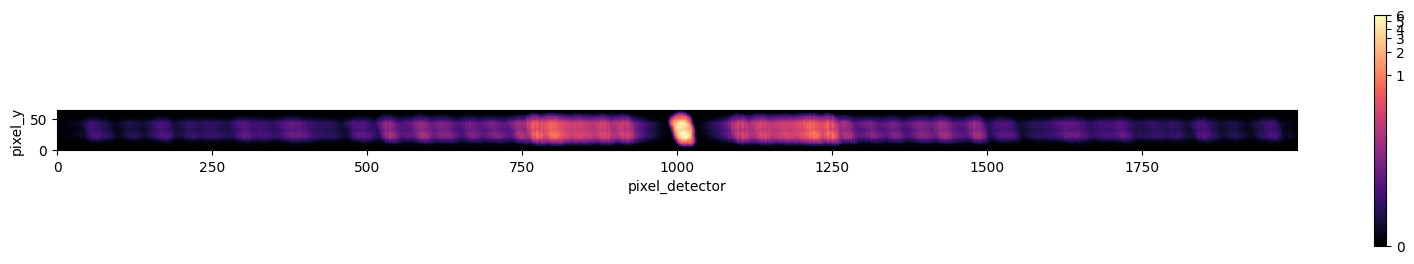

In [53]:
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot()
moxsi_counts_simulated.plot.imshow(ax=ax, cmap='magma', norm=ImageNormalize(stretch=LogStretch()), interpolation='none')
ax.set_aspect(1)

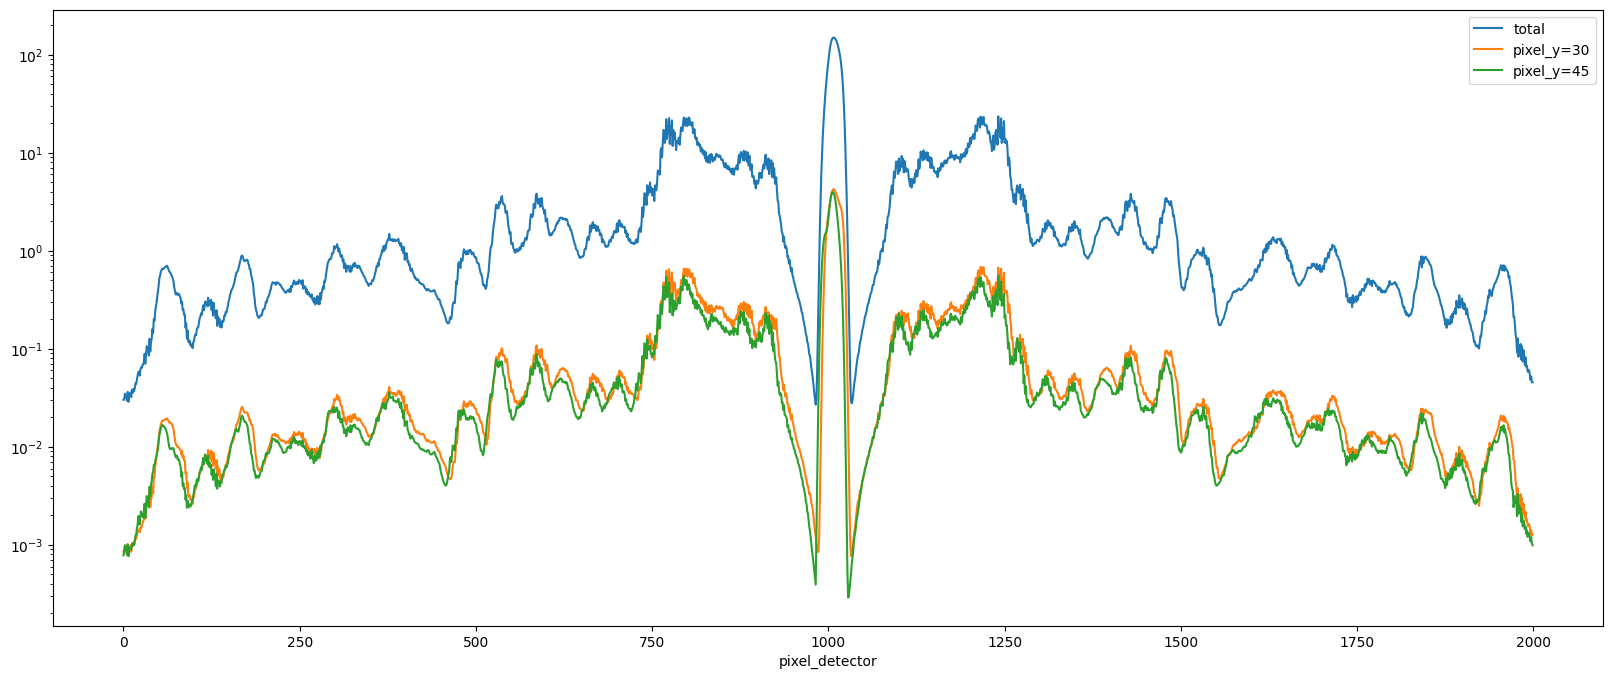

In [208]:
fig = plt.figure(figsize=(20,8))
moxsi_counts_simulated.sum(dim='pixel_y').plot(label='total')
moxsi_counts_simulated.isel(pixel_y=30).plot(label='pixel_y=30')
moxsi_counts_simulated.isel(pixel_y=45).plot(label='pixel_y=45')
plt.yscale('log')
#plt.ylim(1e-4,1)
plt.legend()

In [209]:
x_ = response_matrix_total[150:204,...].stack(pixel_logT=('pixel_x', 'log_temperature'))

In [210]:
model = ElasticNet(
    positive=True,
    alpha=0.05,
    l1_ratio=2.5e-5,
    max_iter=2000,
    fit_intercept=False,
)

In [211]:
model.fit(x_.values*SCALING_CONSTANT, moxsi_counts_simulated[40,:].values, )

ElasticNet(alpha=0.05, fit_intercept=False, l1_ratio=2.5e-05, max_iter=2000,
           positive=True)

In [212]:
em_coefficients = xarray.DataArray(
    model.coef_,
    dims=['pixel_logT'],
    coords={'pixel_logT': x_.pixel_logT},
)*SCALING_CONSTANT

In [213]:
recovered_moxsi_counts_simulated = x_.dot(em_coefficients, dims=['pixel_logT'])

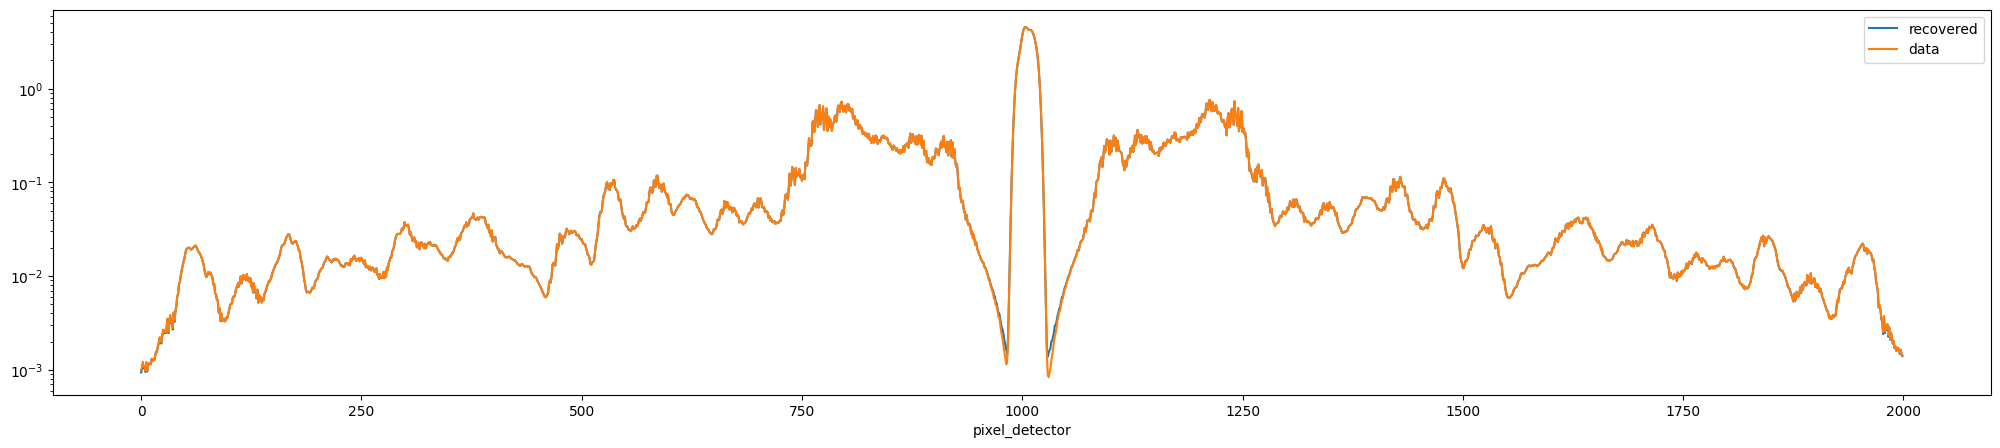

In [214]:
plt.figure(figsize=(25,5))
recovered_moxsi_counts_simulated.plot(label='recovered')
moxsi_counts_simulated[40,:].plot(label='data')
plt.yscale('log')
plt.legend()

In [215]:
em_recovered_simulated = em_coefficients.unstack()

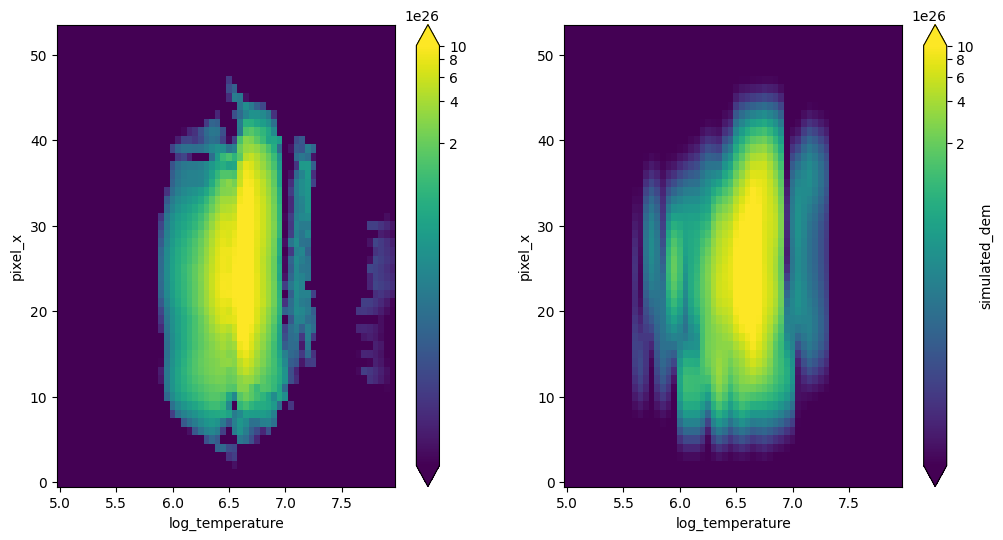

In [216]:
norm = ImageNormalize(vmin=1e23, vmax=1e27, stretch=LogStretch())
plt.figure(figsize=(12,6))
plt.subplot(121)
em_recovered_simulated.plot(norm=norm)
plt.subplot(122)
em_cube_simulated[40,...].plot(norm=norm)

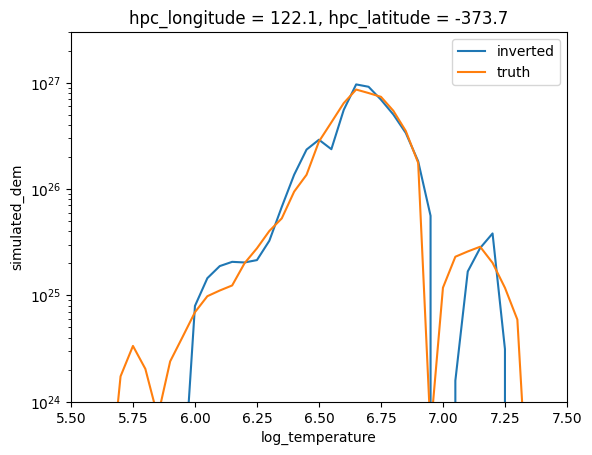

In [227]:
em_recovered_simulated.isel(pixel_x=35).plot(label='inverted')
em_cube_simulated.isel(pixel_y=40, pixel_x=35).plot(label='truth')
plt.yscale('log')
plt.ylim(1e24,3e27)
plt.xlim(5.5,7.5)
plt.legend()

In [ ]:
foo = np.random.rand(10,50,30)

In [ ]:
foo_idx = np.where(foo > 0.5)

In [201]:
foo_idx

(array([0, 0, 0, ..., 9, 9, 9]),
 array([ 0,  0,  0, ..., 49, 49, 49]),
 array([ 0,  1,  2, ..., 23, 25, 28]))

In [202]:
def print_index(iz,iy,ix):
    print(iz)
    print(iy)
    print(ix)

In [204]:
print_index(*foo_idx)

[0 0 0 ... 9 9 9]
[ 0  0  0 ... 49 49 49]
[ 0  1  2 ... 23 25 28]


In [205]:
print_index(*foo_idx[::-1])

[ 0  1  2 ... 23 25 28]
[ 0  0  0 ... 49 49 49]
[0 0 0 ... 9 9 9]
